In [44]:
%load_ext autoreload
%autoreload 2
import sys
import time, os
from style_transfer import *
from helper import *
os.environ["TZ"] = "US/Eastern"
time.tzset()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Packages

Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [11]:
import torch
import torch.nn as nn
import torchvision
import PIL
import numpy as np
from backend.grad import rel_error
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%matplotlib inline

In [12]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')
to_float_cuda = torch.cuda.FloatTensor 

Good to go!


In [46]:
if os.path.isdir('styles'):
  print('Style images exist')

Style images exist


### Backbone Setup

Load a pre-trained backbone model to extract features.

In [47]:
# Load the pre-trained SqueezeNet model.
cnn = torchvision.models.squeezenet1_1(pretrained=True).features
cnn.type(to_float_cuda)

# We don't want to train the model any further, so we don't want PyTorch to waste computation 
# computing gradients on parameters we're never going to update.
for param in cnn.parameters():
    param.requires_grad = False

def extract_features(x, cnn):
    """
    Use the CNN to extract features from the input image x.
    """
    features = []
    prev_feat = x
    for i, module in enumerate(cnn._modules.values()):
        next_feat = module(prev_feat)
        features.append(next_feat)
        prev_feat = next_feat
    return features


def features_from_img(imgpath, imgsize):
    img = preprocess(PIL.Image.open(imgpath), size=imgsize)
    img_var = img.type(to_float_cuda)
    return extract_features(img_var, cnn), img_var


#please disregard warnings about initialization

## Computing Loss

We're going to compute the three components of our loss function now. The loss function is a weighted sum of three terms: content loss + style loss + total variation loss. 

## Content loss
We can generate an image that reflects the content of one image and the style of another by incorporating both in our loss function. We want to penalize deviations from the content of the content image and deviations from the style of the style image. We can then use this hybrid loss function to perform gradient descent **not on the parameters** of the model, but instead **on the pixel values** of our original image.


In [48]:
def content_loss_test(correct):
    content_image = 'styles/tubingen.jpg'
    image_size =  192
    content_layer = 3
    content_weight = 6e-2
    
    c_feats, content_img_var = features_from_img(content_image, image_size)
    
    bad_img = torch.zeros(*content_img_var.data.size()).type(to_float_cuda)
    feats = extract_features(bad_img, cnn)
    
    curr_output = content_loss(content_weight, c_feats[content_layer], feats[content_layer])
    error = rel_error(correct, curr_output)
    print('Maximum error is {:.3f}'.format(error))

content_loss_test(torch.from_numpy(answers['cl_out']).type(to_float_cuda))

Maximum error is 0.000


## Style loss
Now we can tackle the style loss. For a given layer $\ell$, the style loss is defined as follows:

First, compute the Gram matrix G which represents the correlations between the responses of each filter, where F is as above. The Gram matrix is an approximation to the covariance matrix -- we want the activation statistics of our generated image to match the activation statistics of our style image, and matching the (approximate) covariance is one way to do that.

In [49]:
def gram_matrix_test(correct):
    style_image = 'styles/starry_night.jpg'
    style_size = 192
    feats, _ = features_from_img(style_image, style_size)
    # YOUR_TURN: Impelement the gram_matrix function
    student_output = gram_matrix(feats[5].clone())
    error = rel_error(correct, student_output)
    print('Maximum error is {:.3f}'.format(error))

gram_matrix_test(torch.from_numpy(answers['gm_out']).type(to_float_cuda))

Maximum error is 0.000


Next, implement the `style_loss` and run the cell below to test it. The error should be less than 0.001.

In [50]:
def style_loss_test(correct):
    content_image = 'styles/tubingen.jpg'
    style_image = 'styles/starry_night.jpg'
    image_size =  192
    style_size = 192
    style_layers = [1, 4, 6, 7]
    style_weights = [300000, 1000, 15, 3]
    
    c_feats, _ = features_from_img(content_image, image_size)    
    feats, _ = features_from_img(style_image, style_size)
    style_targets = []
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))
    # YOUR_TURN: Impelement the style_loss function
    student_output = style_loss(c_feats, style_layers, style_targets, style_weights)
    error = rel_error(correct, student_output)
    print('Error is {:.6f}'.format(error))

    
style_loss_test(torch.from_numpy(answers['sl_out']).type(to_float_cuda))

Error is 0.000015


## Total-variation regularization
It turns out that it's helpful to also encourage smoothness in the image. We can do this by adding another term to our loss that penalizes wiggles or "total variation" in the pixel values. 



In [51]:
def tv_loss_test(correct):
    content_image = 'styles/tubingen.jpg'
    image_size =  192
    tv_weight = 2e-2

    content_img = preprocess(PIL.Image.open(content_image), size=image_size).type(to_float_cuda)
    
    student_output = tv_loss(content_img, tv_weight)
    error = rel_error(correct, student_output)
    print('Error is {:.8f}'.format(error))
    
tv_loss_test(torch.from_numpy(answers['tv_out']).type(to_float_cuda))

Error is 0.00000000


Now we're ready to string it all together (you shouldn't have to modify this function):

In [52]:
def style_transfer(content_image, style_image, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, tv_weight, init_random = False, save_image=False, result_filename=None):
    """
    Run style transfer!
    """
    
    # Extract features for the content image
    content_img = preprocess(PIL.Image.open(content_image), size=image_size).type(to_float_cuda)
    feats = extract_features(content_img, cnn)
    content_target = feats[content_layer].clone()

    # Extract features for the style image
    style_img = preprocess(PIL.Image.open(style_image), size=style_size).type(to_float_cuda)
    feats = extract_features(style_img, cnn)
    style_targets = []
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))

    # Initialize output image to content image or nois
    if init_random:
        img = torch.Tensor(content_img.size()).uniform_(0, 1).type(to_float_cuda)
    else:
        img = content_img.clone().type(to_float_cuda)

    # We do want the gradient computed on our image!
    img.requires_grad_()
    
    # Set up optimization hyperparameters
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180

    # Note that we are optimizing the pixel values of the image by passing
    # in the img Torch tensor, whose requires_grad flag is set to True
    optimizer = torch.optim.Adam([img], lr=initial_lr)
    
    f, axarr = plt.subplots(1,2)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].set_title('Content Source Img.')
    axarr[1].set_title('Style Source Img.')
    axarr[0].imshow(deprocess(content_img.cpu()))
    axarr[1].imshow(deprocess(style_img.cpu()))
    plt.show()
    plt.figure()
    
    for t in range(200):
        if t < 190:
            img.data.clamp_(-1.5, 1.5)
        optimizer.zero_grad()

        feats = extract_features(img, cnn)
        
        # Compute loss
        c_loss = content_loss(content_weight, feats[content_layer], content_target)
        s_loss = style_loss(feats, style_layers, style_targets, style_weights)
        t_loss = tv_loss(img, tv_weight) 
        loss = c_loss + s_loss + t_loss
        
        loss.backward()

        # Perform gradient descents on our image values
        if t == decay_lr_at:
            optimizer = torch.optim.Adam([img], lr=decayed_lr)
        optimizer.step()

        if t % 100 == 0:
            print('Iteration {}'.format(t))
            plt.axis('off')
            plt.imshow(deprocess(img.data.cpu()))
            plt.show()
    print('Iteration {}'.format(t))
    plt.axis('off')
    plt.imshow(deprocess(img.data.cpu()))
    plt.show() 

## Generating some pictures.

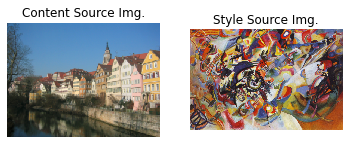

Iteration 0


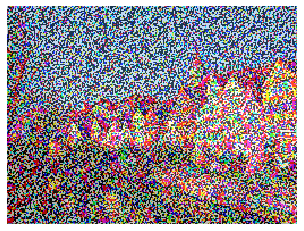

Iteration 100


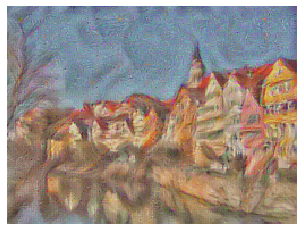

Iteration 199


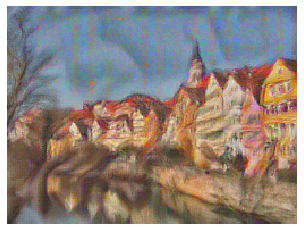

In [53]:
# Composition VII + Tubingen
params1 = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/composition_vii.jpg',
    'image_size' : 192,
    'style_size' : 512,
    'content_layer' : 3,
    'content_weight' : 5e-2, 
    'style_layers' : (1, 4, 6, 7),
    'style_weights' : (20000, 500, 12, 1),
    'tv_weight' : 5e-2,
    'save_image' : True,
    'result_filename' : 'style_transfer_result.jpg'
}

style_transfer(**params1)

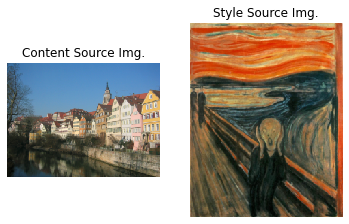

Iteration 0


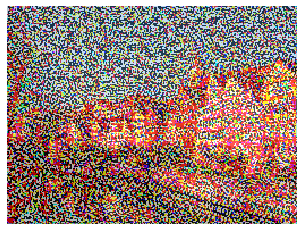

Iteration 100


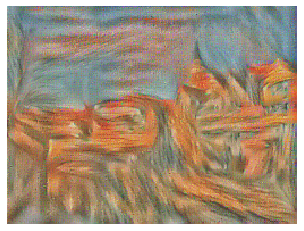

Iteration 199


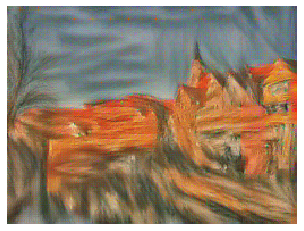

In [54]:
# Scream + Tubingen
params2 = {
    'content_image':'styles/tubingen.jpg',
    'style_image':'styles/the_scream.jpg',
    'image_size':192,
    'style_size':224,
    'content_layer':3,
    'content_weight':3e-2,
    'style_layers':[1, 4, 6, 7],
    'style_weights':[200000, 800, 12, 1],
    'tv_weight':2e-2,
    'save_image' : False
}

style_transfer(**params2)

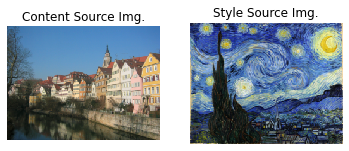

Iteration 0


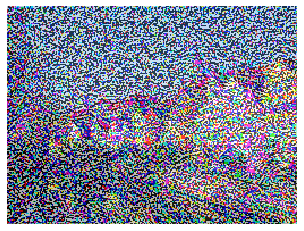

Iteration 100


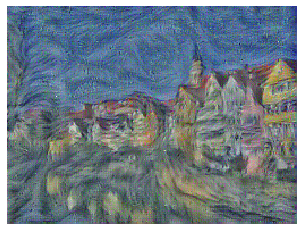

Iteration 199


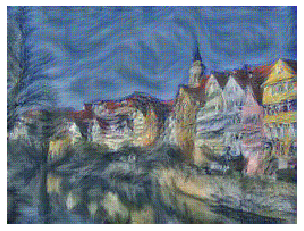

In [55]:
# Starry Night + Tubingen
params3 = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/starry_night.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [300000, 1000, 15, 3],
    'tv_weight' : 2e-2,
    'save_image' : False
}

style_transfer(**params3)

## Feature Inversion
"Understanding Deep Image Representations by Inverting them"

In an attempt to understand the types of features that convolutional networks learn to recognize, a recent paper attempts to reconstruct an image from its feature representation. We can easily implement this idea using image gradients from the pretrained network, which is exactly what we did above (but with two different feature representations).

Now, if we set the style weights to all be 0 and initialize the starting image to random noise instead of the content source image, you'll reconstruct an image from the feature representation of the content source image. You're starting with total noise, but you should end up with something that looks quite a bit like your original image.


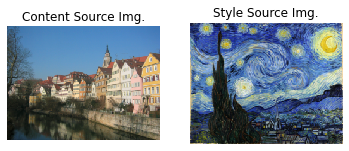

Iteration 0


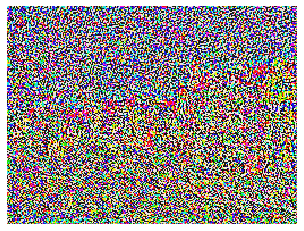

Iteration 100


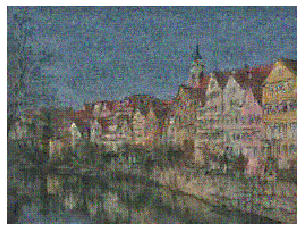

Iteration 199


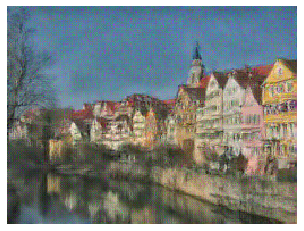

In [43]:
# Feature Inversion -- Starry Night + Tubingen
params_inv = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/starry_night.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [0, 0, 0, 0], # we discard any contributions from style to the loss
    'tv_weight' : 2e-2,
    'init_random': True, # we want to initialize our image to be random
    'save_image' : True,
    'result_filename' : 'feature_inversion_result.jpg'
}

style_transfer(**params_inv)